In [1]:
'''
experiment - Semi-Converging EM
'''
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import agent
import skew_chain as fl
import utils

import tensorflow as tf
tf.enable_eager_execution()  # for M-EM

# pretify
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')  # Ignore deprecation warnings (new numpy)

In [2]:
'''
experiment setting
'''
# parameters
len_episodes = 100
num_episodes = 20
num_states = 5
num_actions = 2
discount = 1
num_experiments = 200
# reward = r(s,a) = n(s) x n(a) matrix
# expected reward - as reward is also stochastic)
reward = np.array([[0, 20],
                   [0, 2],
                   [0, 2],
                   [0, 2],
                   [200, 2]])
# start_dist (always starts in state 0)
start_dist = np.array([1, 0, 0, 0, 0])

75.42
[[0.41 0.89 0.98 1.   1.  ]
 [0.59 0.11 0.02 0.   0.  ]]
101.22
[[0.61 0.9  0.99 1.   1.  ]
 [0.39 0.1  0.01 0.   0.  ]]
70.02
[[0.25 0.88 1.   0.99 1.  ]
 [0.75 0.12 0.   0.01 0.  ]]
43.0
[[0.31 0.89 1.   1.   1.  ]
 [0.69 0.11 0.   0.   0.  ]]
45.24
[[0.23 0.96 0.99 0.98 1.  ]
 [0.77 0.04 0.01 0.02 0.  ]]
92.46
[[0.45 0.88 0.96 1.   1.  ]
 [0.55 0.12 0.04 0.   0.  ]]
70.46
[[0.56 0.92 0.95 0.99 1.  ]
 [0.44 0.08 0.05 0.01 0.  ]]
70.42
[[0.22 0.91 1.   1.   1.  ]
 [0.78 0.09 0.   0.   0.  ]]
46.42
[[0.44 0.9  0.99 0.99 1.  ]
 [0.56 0.1  0.01 0.01 0.  ]]
72.44
[[0.7  0.94 0.92 1.   1.  ]
 [0.3  0.06 0.08 0.   0.  ]]
96.64
[[0.31 0.88 0.97 0.99 1.  ]
 [0.69 0.12 0.03 0.01 0.  ]]
90.3
[[0.48 0.85 0.98 1.   1.  ]
 [0.52 0.15 0.02 0.   0.  ]]
60.42
[[0.34 0.91 0.96 0.98 1.  ]
 [0.66 0.09 0.04 0.02 0.  ]]
66.6
[[0.33 0.96 0.95 0.99 1.  ]
 [0.67 0.04 0.05 0.01 0.  ]]
71.86
[[0.54 0.88 0.96 0.99 1.  ]
 [0.46 0.12 0.04 0.01 0.  ]]
61.46
[[0.29 0.89 0.91 1.   1.  ]
 [0.71 0.11 0.09 0.   0

81.46
[[0.55 0.9  0.97 1.   1.  ]
 [0.45 0.1  0.03 0.   0.  ]]
82.6
[[0.44 0.89 0.98 1.   1.  ]
 [0.56 0.11 0.02 0.   0.  ]]
61.02
[[0.34 0.94 0.96 1.   1.  ]
 [0.66 0.06 0.04 0.   0.  ]]
56.86
[[0.32 0.9  0.96 1.   1.  ]
 [0.68 0.1  0.04 0.   0.  ]]
101.02
[[0.71 0.87 0.98 0.99 1.  ]
 [0.29 0.13 0.02 0.01 0.  ]]
79.0
[[0.6  0.86 0.99 1.   1.  ]
 [0.4  0.14 0.01 0.   0.  ]]
101.02
[[0.74 0.9  0.97 1.   1.  ]
 [0.26 0.1  0.03 0.   0.  ]]
74.86
[[0.61 0.91 0.99 1.   1.  ]
 [0.39 0.09 0.01 0.   0.  ]]
78.64
[[0.55 0.9  0.96 0.99 1.  ]
 [0.45 0.1  0.04 0.01 0.  ]]
53.08
[[0.53 0.89 0.99 1.   1.  ]
 [0.47 0.11 0.01 0.   0.  ]]
75.6
[[0.39 0.91 0.98 1.   1.  ]
 [0.61 0.09 0.02 0.   0.  ]]
75.84
[[0.63 0.89 0.93 1.   1.  ]
 [0.37 0.11 0.07 0.   0.  ]]
65.4
[[0.38 0.92 1.   0.99 1.  ]
 [0.62 0.08 0.   0.01 0.  ]]
56.08
[[0.52 0.95 0.95 1.   1.  ]
 [0.48 0.05 0.05 0.   0.  ]]
97.62
[[0.36 0.94 0.99 1.   1.  ]
 [0.64 0.06 0.01 0.   0.  ]]
46.02
[[0.29 0.97 0.96 1.   1.  ]
 [0.71 0.03 0.04 0.   0

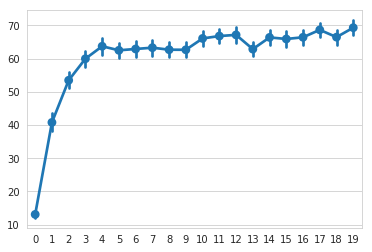

In [3]:
'''
ML-EM
'''
reward_data=[]
for _ in tqdm(range(num_experiments)):
    # make agent bond
    bond = agent.MLEM(num_actions,
                      num_states,
                      discount,
                      len_episodes)
    bond.reward = np.copy(reward)
    bond.start_dist = np.copy(start_dist)

    # for every episode
    avg_reward_history = []
    for _ in range(num_episodes):
        # reset total reward per episode count
        total_reward = 0
        bond.reset()
        game = fl.make_game()
        obs = game.its_showtime()
        for _ in range(len_episodes):
            action = bond.play(utils.get_location(obs, char='O'))
            obs = game.play(action)
            if not obs[1] is None:
                total_reward += obs[1]
        # learn after the end of episode
        bond.learn(nconv=0.01)
        # add average reward to list
        avg_reward_history.append(total_reward/len_episodes)
        # quit game
        game.play(5)
    reward_data.append(avg_reward_history)
    print(avg_reward_history[-1])
    print(np.round(bond.policy, 2))

ml_reward_data = np.array(reward_data)
# plot rewards
sns.pointplot(data=ml_reward_data, ci=90)
plt.show()

51.06
[[0.6  0.94 0.95 1.   1.  ]
 [0.4  0.06 0.05 0.   0.  ]]
70.84
[[0.35 0.89 0.97 0.99 1.  ]
 [0.65 0.11 0.03 0.01 0.  ]]
39.02
[[0.26 0.92 0.95 1.   1.  ]
 [0.74 0.08 0.05 0.   0.  ]]
50.82
[[0.18 0.98 0.95 1.   1.  ]
 [0.82 0.02 0.05 0.   0.  ]]
38.82
[[0.44 0.92 0.98 0.99 1.  ]
 [0.56 0.08 0.02 0.01 0.  ]]
34.62
[[0.39 0.9  1.   0.99 1.  ]
 [0.61 0.1  0.   0.01 0.  ]]
98.46
[[0.48 0.88 0.96 1.   1.  ]
 [0.52 0.12 0.04 0.   0.  ]]
112.66
[[0.4  0.91 0.98 1.   1.  ]
 [0.6  0.09 0.02 0.   0.  ]]
99.62
[[0.72 0.87 1.   1.   1.  ]
 [0.28 0.13 0.   0.   0.  ]]
103.4
[[0.54 0.95 0.94 1.   1.  ]
 [0.46 0.05 0.06 0.   0.  ]]
43.64
[[0.47 0.89 0.97 1.   1.  ]
 [0.53 0.11 0.03 0.   0.  ]]
57.46
[[0.12 0.93 0.98 0.97 1.  ]
 [0.88 0.07 0.02 0.03 0.  ]]
83.82
[[0.43 0.92 0.95 0.99 1.  ]
 [0.57 0.08 0.05 0.01 0.  ]]
45.44
[[0.47 0.9  0.95 1.   1.  ]
 [0.53 0.1  0.05 0.   0.  ]]
49.84
[[0.42 0.98 1.   0.97 1.  ]
 [0.58 0.02 0.   0.03 0.  ]]
49.46
[[0.72 0.9  0.97 1.   1.  ]
 [0.28 0.1  0.03 0. 

62.06
[[0.27 0.89 0.95 1.   1.  ]
 [0.73 0.11 0.05 0.   0.  ]]
54.86
[[0.67 0.92 0.95 0.99 1.  ]
 [0.33 0.08 0.05 0.01 0.  ]]
41.04
[[0.3  0.88 0.98 1.   1.  ]
 [0.7  0.12 0.02 0.   0.  ]]
76.08
[[0.36 0.86 0.97 1.   1.  ]
 [0.64 0.14 0.03 0.   0.  ]]
59.6
[[0.54 0.97 0.96 1.   1.  ]
 [0.46 0.03 0.04 0.   0.  ]]
42.4
[[0.29 0.9  0.98 1.   1.  ]
 [0.71 0.1  0.02 0.   0.  ]]
62.82
[[0.24 0.91 0.98 0.99 1.  ]
 [0.76 0.09 0.02 0.01 0.  ]]
70.04
[[0.32 0.93 0.98 1.   1.  ]
 [0.68 0.07 0.02 0.   0.  ]]
68.82
[[0.26 0.94 0.98 1.   1.  ]
 [0.74 0.06 0.02 0.   0.  ]]
40.2
[[0.16 0.94 1.   1.   1.  ]
 [0.84 0.06 0.   0.   0.  ]]
86.44
[[0.44 0.89 0.96 0.99 1.  ]
 [0.56 0.11 0.04 0.01 0.  ]]
52.64
[[0.34 0.92 0.98 0.99 1.  ]
 [0.66 0.08 0.02 0.01 0.  ]]
65.26
[[0.5  0.89 0.98 0.99 1.  ]
 [0.5  0.11 0.02 0.01 0.  ]]
52.26
[[0.54 0.89 0.99 0.97 1.  ]
 [0.46 0.11 0.01 0.03 0.  ]]
80.64
[[0.44 0.87 0.99 1.   1.  ]
 [0.56 0.13 0.01 0.   0.  ]]
90.82
[[0.41 0.91 0.95 0.99 1.  ]
 [0.59 0.09 0.05 0.01 0.

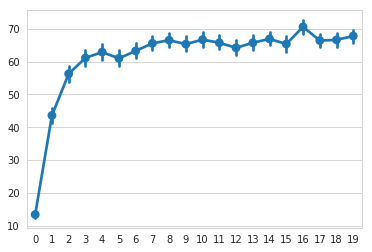

In [4]:
'''
Semi-EM
'''
reward_data=[]
for _ in tqdm(range(num_experiments)):
    # make agent bond
    bond = agent.MLEM(num_actions,
                      num_states,
                      discount,
                      len_episodes)
    bond.reward = np.copy(reward)
    bond.start_dist = np.copy(start_dist)

    # for every episode
    avg_reward_history = []
    for _ in range(num_episodes):
        # reset total reward per episode count
        total_reward = 0
        bond.reset()
        game = fl.make_game()
        obs = game.its_showtime()
        for _ in range(len_episodes):
            action = bond.play(utils.get_location(obs, char='O'))
            obs = game.play(action)
            if not obs[1] is None:
                total_reward += obs[1]
        # learn after the end of episode
        bond.learn(nconv=0.01)
        # add average reward to list
        avg_reward_history.append(total_reward/len_episodes)
        # quit game
        game.play(5)
    reward_data.append(avg_reward_history)
    print(avg_reward_history[-1])
    print(np.round(bond.policy, 2))

semi_ml_reward_data = np.array(reward_data)
# plot rewards
sns.pointplot(data=semi_ml_reward_data, ci=90)
plt.show()

94.82
[[0.27 0.91 0.98 0.98 1.  ]
 [0.73 0.09 0.02 0.02 0.  ]]
35.02
[[0.36 0.91 0.98 1.   1.  ]
 [0.64 0.09 0.02 0.   0.  ]]
72.0
[[0.61 0.89 0.99 1.   1.  ]
 [0.39 0.11 0.01 0.   0.  ]]
84.82
[[0.65 0.92 0.95 0.97 1.  ]
 [0.35 0.08 0.05 0.03 0.  ]]
71.46
[[0.46 0.88 0.98 1.   1.  ]
 [0.54 0.12 0.02 0.   0.  ]]
74.62
[[0.36 0.9  0.96 1.   1.  ]
 [0.64 0.1  0.04 0.   0.  ]]
64.06
[[0.49 0.89 0.99 1.   1.  ]
 [0.51 0.11 0.01 0.   0.  ]]
60.04
[[0.52 0.91 0.94 1.   1.  ]
 [0.48 0.09 0.06 0.   0.  ]]
107.42
[[0.55 0.89 0.98 1.   1.  ]
 [0.45 0.11 0.02 0.   0.  ]]
60.0
[[0.69 0.87 0.99 1.   1.  ]
 [0.31 0.13 0.01 0.   0.  ]]
79.02
[[0.46 0.91 0.99 1.   1.  ]
 [0.54 0.09 0.01 0.   0.  ]]
71.8
[[0.41 0.94 0.96 1.   1.  ]
 [0.59 0.06 0.04 0.   0.  ]]
81.4
[[0.28 0.93 0.98 1.   1.  ]
 [0.72 0.07 0.02 0.   0.  ]]
67.48
[[0.21 0.87 1.   1.   1.  ]
 [0.79 0.13 0.   0.   0.  ]]
84.4
[[0.26 0.91 1.   1.   1.  ]
 [0.74 0.09 0.   0.   0.  ]]
70.02
[[0.42 0.94 0.95 1.   1.  ]
 [0.58 0.06 0.05 0.   0. 

61.8
[[0.37 0.91 0.98 1.   1.  ]
 [0.63 0.09 0.02 0.   0.  ]]
33.7
[[0.58 0.88 0.99 1.   1.  ]
 [0.42 0.12 0.01 0.   0.  ]]
49.2
[[0.19 0.94 0.99 1.   1.  ]
 [0.81 0.06 0.01 0.   0.  ]]
82.24
[[0.41 0.9  1.   1.   1.  ]
 [0.59 0.1  0.   0.   0.  ]]
80.02
[[0.64 0.89 1.   1.   1.  ]
 [0.36 0.11 0.   0.   0.  ]]
64.8
[[0.51 0.92 0.98 1.   1.  ]
 [0.49 0.08 0.02 0.   0.  ]]
56.24
[[0.36 0.95 0.97 0.98 1.  ]
 [0.64 0.05 0.03 0.02 0.  ]]
85.62
[[0.57 0.86 0.98 1.   1.  ]
 [0.43 0.14 0.02 0.   0.  ]]
43.8
[[0.35 0.97 1.   0.98 1.  ]
 [0.65 0.03 0.   0.02 0.  ]]
78.8
[[0.47 0.89 0.94 1.   1.  ]
 [0.53 0.11 0.06 0.   0.  ]]
65.4
[[0.46 0.91 0.96 1.   1.  ]
 [0.54 0.09 0.04 0.   0.  ]]
75.22
[[0.71 0.9  0.99 1.   1.  ]
 [0.29 0.1  0.01 0.   0.  ]]
90.66
[[0.82 0.86 0.98 1.   1.  ]
 [0.18 0.14 0.02 0.   0.  ]]
75.66
[[0.38 0.88 1.   0.99 1.  ]
 [0.62 0.12 0.   0.01 0.  ]]
87.82
[[0.6  0.89 0.99 1.   1.  ]
 [0.4  0.11 0.01 0.   0.  ]]
56.26
[[0.24 0.92 0.97 1.   1.  ]
 [0.76 0.08 0.03 0.   0.  ]]

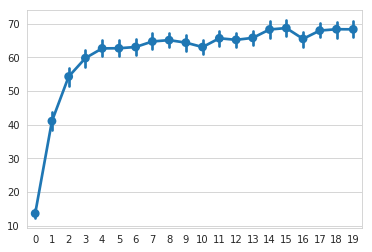

In [5]:
'''
M-EM
'''
reward_data = []
for _ in tqdm(range(num_experiments)):
    # make agent bond
    bond = agent.MontyBay(num_actions,
                      num_states,
                      discount,
                      len_episodes,
                      num_sams=100)  # no. of samples for Monte Carlo approximation
    bond.reward = np.copy(reward)
    bond.start_dist = np.copy(start_dist)

    # for every episode
    avg_reward_history = []
    for _ in range(num_episodes):
        # reset total reward per episode count
        total_reward = 0
        bond.reset()
        game = fl.make_game()
        obs = game.its_showtime()
        for _ in range(len_episodes):
            action = bond.play(utils.get_location(obs, char='O'))
            obs = game.play(action)
            if not obs[1] is None:
                total_reward += obs[1]
        #learn after the end of episode
        bond.learn(nconv=0.01)
        # add average reward to list
        avg_reward_history.append(total_reward/len_episodes)
        # quit game
        game.play(5)
    reward_data.append(avg_reward_history)
    print(avg_reward_history[-1])
    print(np.round(bond.policy, 2))

vb_reward_data = np.array(reward_data)
# plot rewards
sns.pointplot(data=vb_reward_data, ci=90)
plt.show()

98.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
88.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
60.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
82.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
80.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
78.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
66.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
52.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
68.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
58.2
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
72.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
78.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
72.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
66.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
66.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
72.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
102.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
66.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
68.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
80.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
94.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
64.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
108.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
70.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0

80.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
52.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
96.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
44.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
82.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
42.0
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]



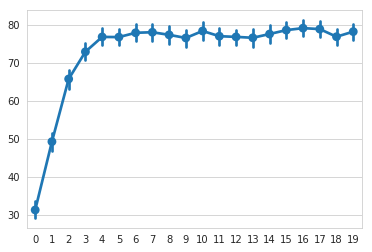

In [6]:
'''
Semi-M-EM
'''
reward_data = []
for _ in tqdm(range(num_experiments)):
    # make agent bond
    bond = agent.MontyBay(num_actions,
                      num_states,
                      discount,
                      len_episodes,
                      num_sams=100)  # no. of samples for Monte Carlo approximation
    bond.reward = np.copy(reward)
    bond.start_dist = np.copy(start_dist)

    # for every episode
    avg_reward_history = []
    for _ in range(num_episodes):
        # reset total reward per episode count
        total_reward = 0
        bond.reset()
        game = fl.make_game()
        obs = game.its_showtime()
        for _ in range(len_episodes):
            action = bond.play(utils.get_location(obs, char='O'))
            obs = game.play(action)
            if not obs[1] is None:
                total_reward += obs[1]
            #learn after each step
            bond.learn(niter=1)
        # add average reward to list
        avg_reward_history.append(total_reward/len_episodes)
        # quit game
        game.play(5)
    reward_data.append(avg_reward_history)
    print(avg_reward_history[-1])
    print(np.round(bond.policy, 2))

semi_vb_reward_data = np.array(reward_data)
# plot rewards
sns.pointplot(data=semi_vb_reward_data, ci=90)
plt.show()

In [7]:
'''
a dumb hack to prepare data for plotting
'''
log = pd.DataFrame(columns=['episode',
                           'average-reward/time-step',
                           'EM'])
for nx in range(num_experiments):
    for ne in range(num_episodes):
        log=log.append(pd.DataFrame({'episode': ne+1,
                                    'average-reward/time-step': ml_reward_data[nx, ne],
                                    'EM': "ML-EM"}, index=[log.size+1]))
for nx in range(num_experiments):
    for ne in range(num_episodes):
        log=log.append(pd.DataFrame({'episode': ne+1,
                                    'average-reward/time-step': vb_reward_data[nx, ne],
                                    'EM': "M-EM"}, index=[log.size+1]))
for nx in range(num_experiments):
    for ne in range(num_episodes):
        log=log.append(pd.DataFrame({'episode': ne+1,
                                    'average-reward/time-step': semi_ml_reward_data[nx, ne],
                                    'EM': "Semi-EM"}, index=[log.size+1]))
for nx in range(num_experiments):
    for ne in range(num_episodes):
        log=log.append(pd.DataFrame({'episode': ne+1,
                                    'average-reward/time-step': semi_vb_reward_data[nx, ne],
                                    'EM': "Semi-M-EM"}, index=[log.size+1]))

In [8]:
'''
save the reward values
'''
log.to_pickle("exp_bay.pkl")

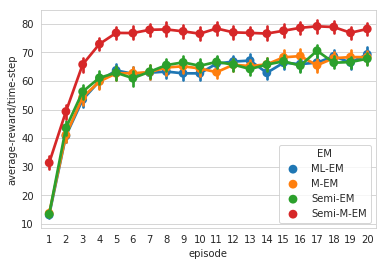

In [9]:
'''
code for plotting a good graph
'''
sns.pointplot(x="episode",
              y="average-reward/time-step",
              hue="EM",
              data=log,
              ci=90)
plt.savefig('exp_bay_result.png', dpi=600, bbox_inches="tight")